# 03_baseline_train
- Author: 
- Date: 2025-10-23
- Goal: Baseline CNN 학습 및 로깅
- Input: 
- Output: 
- Metrics: acc@val, loss@train
- Repro: seed=42, device=auto, config=../configs/


In [1]:
# ================================================================
# 03. Evaluation & Visualization for Classical ML on Colored MNIST
#    - Reads metrics CSVs generated by 02_train_classical_ml.ipynb
#    - Produces:
#        * Summary tables (per task / per model)
#        * Bar plots of metrics vs model
#        * Best model per task selection
#        * (Optionally) show confusion matrix images generated in 02
# ================================================================


# ================================
# Cell 1. Imports & global config
# ================================
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# For displaying confusion matrix images
from PIL import Image

# Notebook
%matplotlib inline

# Matplotlib configuration
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["axes.unicode_minus"] = False

print("[INFO] Libraries imported.")

[INFO] Libraries imported.


In [2]:
# ===================================
# Cell 2. Paths & load metrics / data
# ===================================
BASE_DIR = os.getcwd()

RESULTS_METRICS_DIR = os.path.join(BASE_DIR, "results", "metrics")
RESULTS_FIGURES_DIR = os.path.join(BASE_DIR, "results", "figures")

# Main metrics CSV generated by 02 notebook
METRICS_CSV_PATH = os.path.join(
    RESULTS_METRICS_DIR,
    "classical_ml_all_tasks_metrics.csv"
)

if not os.path.exists(METRICS_CSV_PATH):
    raise FileNotFoundError(f"[ERROR] Metrics CSV not found: {METRICS_CSV_PATH}")

metrics_df = pd.read_csv(METRICS_CSV_PATH)

print("[INFO] Loaded metrics CSV.")
print("  Path :", METRICS_CSV_PATH)
print("  Shape:", metrics_df.shape)
print("\n[HEAD]\n", metrics_df.head())

# If you want per-task CSVs (optional, but convenient)
PER_TASK_CSV = {
    "digit": os.path.join(RESULTS_METRICS_DIR, "digit_classical_ml_metrics.csv"),
    "fg":    os.path.join(RESULTS_METRICS_DIR, "fg_classical_ml_metrics.csv"),
    "bg":    os.path.join(RESULTS_METRICS_DIR, "bg_classical_ml_metrics.csv"),
}

per_task_metrics = {}
for task, path in PER_TASK_CSV.items():
    if os.path.exists(path):
        per_task_metrics[task] = pd.read_csv(path)
        print(f"[INFO] Loaded per-task CSV for '{task}': {path}, shape={per_task_metrics[task].shape}")
    else:
        print(f"[WARN] Per-task CSV not found for '{task}': {path}")


# If you want to reload the preprocessed dataset (for qualitative plots),
# you can also load the npz from 01 notebook.
PROC_DIR = os.path.join(BASE_DIR, "data", "processed", "colored_mnist")
NPZ_PATH = os.path.join(PROC_DIR, "colored_mnist_100k_train_val.npz")

if os.path.exists(NPZ_PATH):
    data_npz = np.load(NPZ_PATH)
    X_train = data_npz["X_train"]
    X_val   = data_npz["X_val"]

    y_digit_train = data_npz["y_digit_train"]
    y_digit_val   = data_npz["y_digit_val"]

    y_fg_train = data_npz["y_fg_train"]
    y_fg_val   = data_npz["y_fg_val"]

    y_bg_train = data_npz["y_bg_train"]
    y_bg_val   = data_npz["y_bg_val"]

    print("\n[INFO] Reloaded preprocessed colored MNIST npz for visualization.")
    print("  X_train:", X_train.shape, "X_val:", X_val.shape)
else:
    data_npz = None
    print("\n[WARN] Preprocessed npz not found. Some qualitative plots will be skipped.")

IMG_SHAPE = (28, 28, 3)

[INFO] Loaded metrics CSV.
  Path : /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics/classical_ml_all_tasks_metrics.csv
  Shape: (6, 8)

[HEAD]
     task                                          task_desc model split  \
0     bg  Background color classification (7 classes, RO...   xgb   val   
1     bg  Background color classification (7 classes, RO...   knn   val   
2  digit                         Digit classification (0-9)   xgb   val   
3  digit                         Digit classification (0-9)   knn   val   
4     fg  Foreground color classification (7 classes, RO...   xgb   val   

   accuracy  precision    recall        f1  
0   1.00000   1.000000  1.000000  1.000000  
1   0.99985   0.999848  0.999848  0.999848  
2   0.93115   0.930945  0.930807  0.930778  
3   0.90195   0.906147  0.900603  0.901768  
4   0.99975   0.999749  0.999751  0.999750  
[INFO] Loaded per-task CSV for 'digit': /Users/jaehun_jung/colored-mnist-classification/notebooks/results/met

In [3]:
# =======================================
# Cell 3. Basic EDA on metrics & overview
# =======================================
print("\n===== Unique tasks in metrics_df =====")
print(metrics_df["task"].unique())

print("\n===== Unique models in metrics_df =====")
print(metrics_df["model"].unique())

print("\n===== Unique splits in metrics_df =====")
print(metrics_df["split"].unique())

print("\n===== Summary stats by task & model =====")
summary = metrics_df.groupby(["task", "model", "split"]).agg(
    accuracy=("accuracy", "mean"),
    precision=("precision", "mean"),
    recall=("recall", "mean"),
    f1=("f1", "mean"),
).reset_index()
print(summary.head(20))


===== Unique tasks in metrics_df =====
['bg' 'digit' 'fg']

===== Unique models in metrics_df =====
['xgb' 'knn']

===== Unique splits in metrics_df =====
['val']

===== Summary stats by task & model =====
    task model split  accuracy  precision    recall        f1
0     bg   knn   val   0.99985   0.999848  0.999848  0.999848
1     bg   xgb   val   1.00000   1.000000  1.000000  1.000000
2  digit   knn   val   0.90195   0.906147  0.900603  0.901768
3  digit   xgb   val   0.93115   0.930945  0.930807  0.930778
4     fg   knn   val   0.85140   0.875711  0.851614  0.851282
5     fg   xgb   val   0.99975   0.999749  0.999751  0.999750


[INFO] Saved barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/bg_accuracy_val_barplot.png


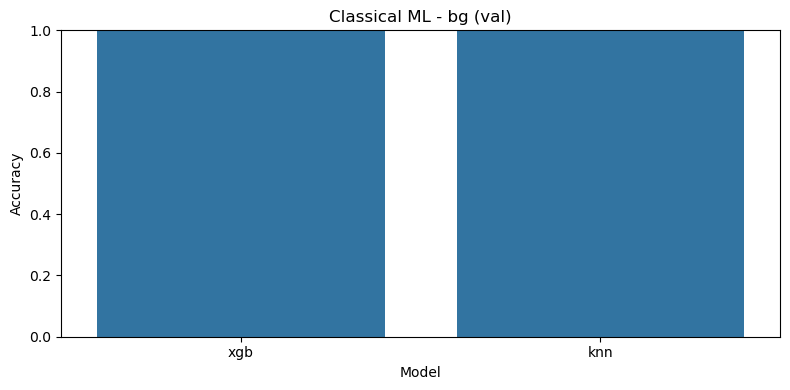

[INFO] Saved barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/bg_f1_val_barplot.png


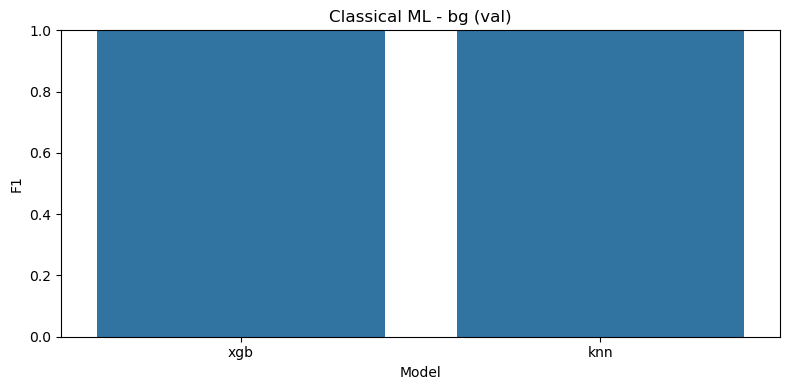

[INFO] Saved barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/digit_accuracy_val_barplot.png


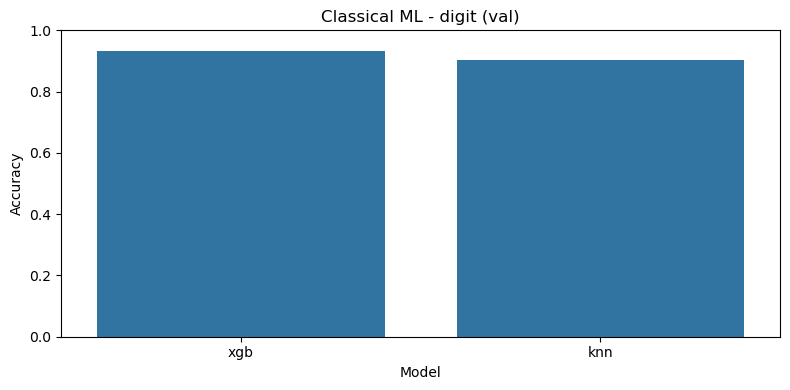

[INFO] Saved barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/digit_f1_val_barplot.png


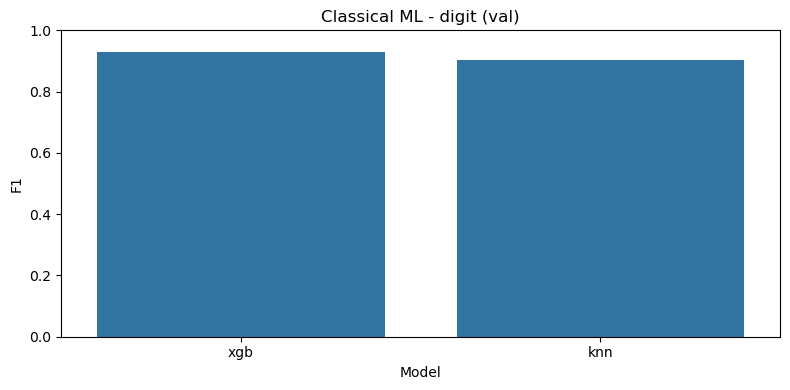

[INFO] Saved barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/fg_accuracy_val_barplot.png


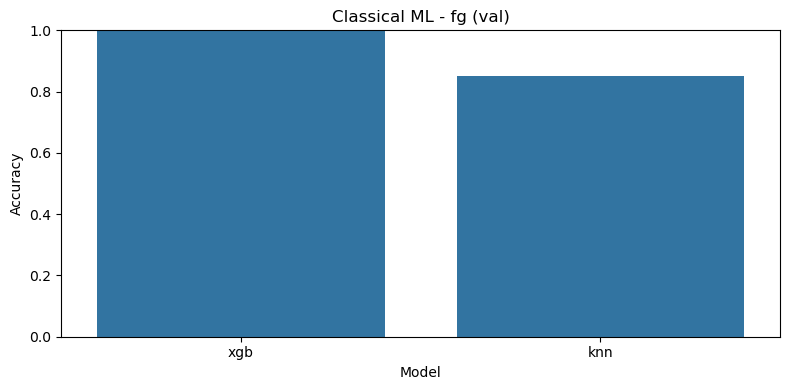

[INFO] Saved barplot to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/figures/fg_f1_val_barplot.png


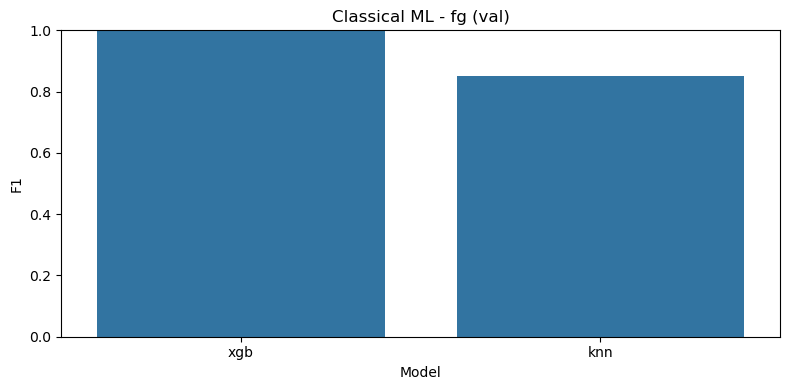

In [4]:
# ==========================================
# Cell 4. Plotting helpers for metric vs model
# ==========================================
def plot_metric_bar_for_task(
    df,
    task_name,
    metric="accuracy",
    split="val",
    title_prefix="",
    save_dir=None,
):
    """
    Plot a bar chart of given metric vs model for a single task.
    """
    mask = (df["task"] == task_name) & (df["split"] == split)
    sub = df[mask].copy()

    if sub.empty:
        print(f"[WARN] No rows found for task='{task_name}', split='{split}'.")
        return

    # Sort models by metric descending
    sub = sub.sort_values(by=metric, ascending=False)

    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=sub,
        x="model",
        y=metric,
    )
    plt.ylim(0.0, 1.0)
    plt.xlabel("Model")
    plt.ylabel(metric.capitalize())
    if title_prefix:
        plt.title(f"{title_prefix} - {task_name} ({split})")
    else:
        plt.title(f"{metric.capitalize()} vs Model - task={task_name}, split={split}")
    plt.tight_layout()

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(
            save_dir,
            f"{task_name}_{metric}_{split}_barplot.png",
        )
        plt.savefig(save_path, dpi=200)
        print("[INFO] Saved barplot to:", save_path)

    plt.show()


# Example usage (you can run/skip selectively)
for task_name in metrics_df["task"].unique():
    for metric in ["accuracy", "f1"]:
        plot_metric_bar_for_task(
            df=metrics_df,
            task_name=task_name,
            metric=metric,
            split="val",
            title_prefix="Classical ML",
            save_dir=RESULTS_FIGURES_DIR,
        )



In [5]:
# ==========================================
# Cell 5. Best model selection per task
# ==========================================
def select_best_model_per_task(df, metric="accuracy", split="val"):
    """
    For each task, select the model with the highest given metric on a specific split.
    Returns a DataFrame with the best row per task.
    """
    mask = df["split"] == split
    sub = df[mask].copy()

    # For each task, pick row with max metric
    best_rows = []
    for task in sub["task"].unique():
        sub_task = sub[sub["task"] == task]
        idx_max = sub_task[metric].idxmax()
        best_rows.append(sub_task.loc[idx_max])

    best_df = pd.DataFrame(best_rows).reset_index(drop=True)
    return best_df

best_by_acc = select_best_model_per_task(
    df=metrics_df,
    metric="accuracy",
    split="val",
)

print("\n===== Best model per task (by validation accuracy) =====")
print(best_by_acc)

# Save this table for report
best_acc_csv_path = os.path.join(
    RESULTS_METRICS_DIR,
    "best_models_per_task_by_val_accuracy.csv",
)
best_by_acc.to_csv(best_acc_csv_path, index=False)
print("\n[INFO] Saved best model summary CSV to:", best_acc_csv_path)



===== Best model per task (by validation accuracy) =====
    task                                          task_desc model split  \
0     bg  Background color classification (7 classes, RO...   xgb   val   
1  digit                         Digit classification (0-9)   xgb   val   
2     fg  Foreground color classification (7 classes, RO...   xgb   val   

   accuracy  precision    recall        f1  
0   1.00000   1.000000  1.000000  1.000000  
1   0.93115   0.930945  0.930807  0.930778  
2   0.99975   0.999749  0.999751  0.999750  

[INFO] Saved best model summary CSV to: /Users/jaehun_jung/colored-mnist-classification/notebooks/results/metrics/best_models_per_task_by_val_accuracy.csv



[INFO] Showing confusion matrices for task='bg'
 Models: ['knn', 'xgb']


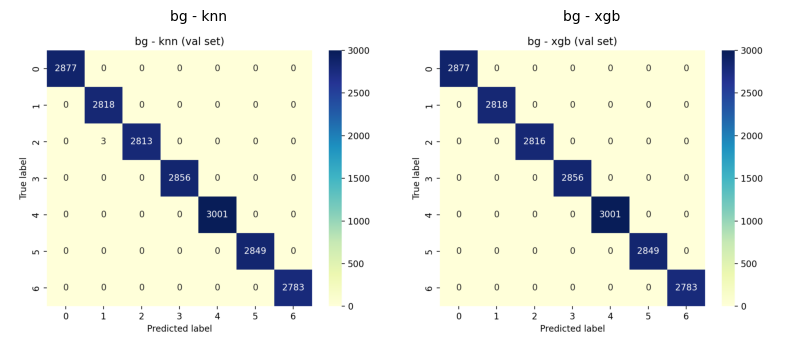


[INFO] Showing confusion matrices for task='digit'
 Models: ['knn', 'xgb']


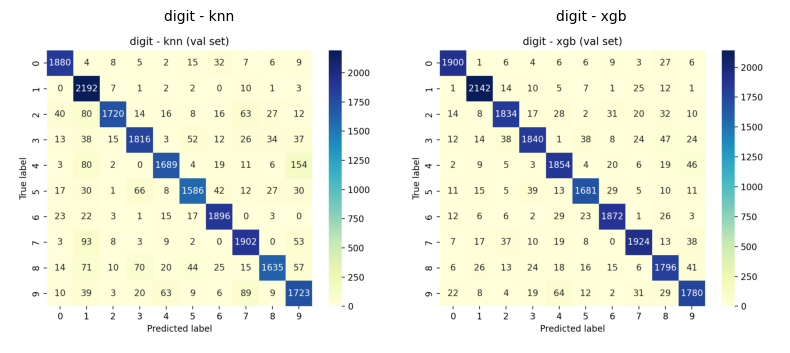


[INFO] Showing confusion matrices for task='fg'
 Models: ['knn', 'xgb']


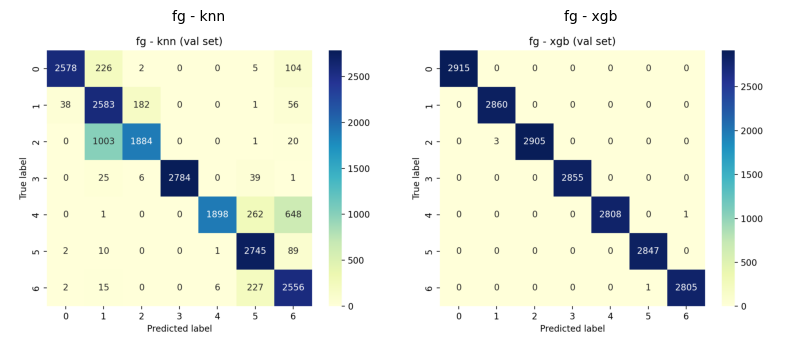

In [6]:
# ==========================================
# Cell 6. Show confusion matrix figures (from 02)
# ==========================================
def show_confusion_matrix_images(
    figures_dir,
    task_name,
    models=None,
    suffix="_val.png",
    n_cols=3,
):
    """
    Display confusion matrix PNGs for a given task.
    Expected filename pattern from 02 notebook:
        cm_{task}_{model}_val.png
    """
    if models is None:
        # auto-detect model names from files
        files = os.listdir(figures_dir)
        models = []
        for f in files:
            if f.startswith(f"cm_{task_name}_") and f.endswith(suffix):
                # pattern: cm_{task}_{model}_val.png
                model = f[len(f"cm_{task_name}_") : -len(suffix)]
                models.append(model)
        models = sorted(set(models))

    if not models:
        print(f"[WARN] No confusion matrix files found for task='{task_name}'.")
        return

    print(f"\n[INFO] Showing confusion matrices for task='{task_name}'")
    print(" Models:", models)

    n = len(models)
    n_cols = min(n_cols, n)
    n_rows = int(np.ceil(n / n_cols))

    plt.figure(figsize=(4 * n_cols, 4 * n_rows))
    for i, model in enumerate(models):
        filename = f"cm_{task_name}_{model}_val.png"
        path = os.path.join(figures_dir, filename)
        if not os.path.exists(path):
            print(f"[WARN] File not found: {path}")
            continue

        img = Image.open(path)
        ax = plt.subplot(n_rows, n_cols, i + 1)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{task_name} - {model}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Example: show confusion matrices for each task
for task_name in metrics_df["task"].unique():
    show_confusion_matrix_images(
        figures_dir=RESULTS_FIGURES_DIR,
        task_name=task_name,
        models=None,  # auto-detect
        suffix="_val.png",
        n_cols=3,
    )

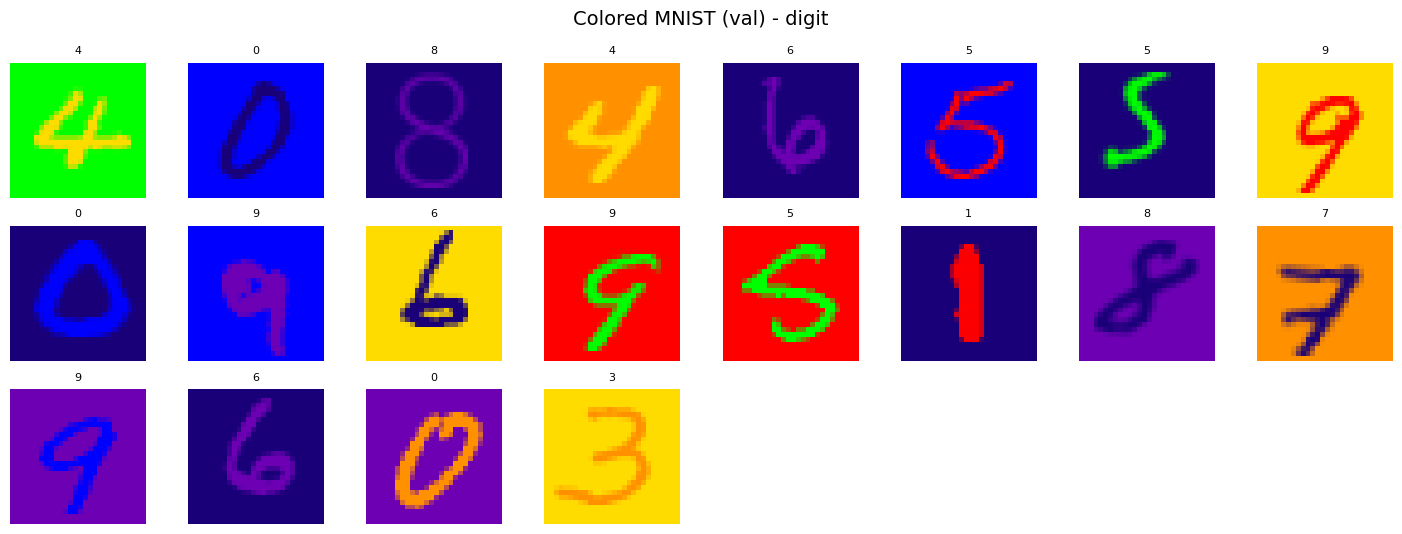

In [7]:
# ==========================================
# Cell 7. Optional: qualitative sample visualization
#         (requires npz + manual re-run of best models)
# ==========================================
# NOTE:
#  - This cell is a template.
#  - To really run qualitative prediction examples,
#    we would need trained pipelines (models) in memory.
#  - Those models live in the 02 notebook.
#
# Here we only show how to reconstruct images and labels.
# You can copy this helper to 02 notebook or reload pickled models
# if you decide to serialize them.

def plot_sample_images_with_labels(
    X_flat,
    y,
    task_name="digit",
    n_samples=16,
    title_prefix="",
):
    """
    Plot sample colored MNIST images with their labels.
    """
    if X_flat is None or y is None:
        print("[WARN] X_flat or y is None. Skipping.")
        return

    n = min(n_samples, X_flat.shape[0])
    idxs = np.random.choice(X_flat.shape[0], size=n, replace=False)
    imgs = X_flat[idxs].reshape(n, *IMG_SHAPE)
    labels = y[idxs]

    cols = min(8, n)
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 1.8, rows * 1.8))
    for i in range(n):
        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(imgs[i] / 255.0)
        ax.axis("off")
        ax.set_title(f"{int(labels[i])}", fontsize=8)

    if title_prefix:
        plt.suptitle(f"{title_prefix} - {task_name}", fontsize=14)
    else:
        plt.suptitle(f"Sample images - task={task_name}", fontsize=14)
    plt.tight_layout()
    plt.show()


if data_npz is not None:
    # Example: show digit labels on validation set
    plot_sample_images_with_labels(
        X_flat=X_val,
        y=y_digit_val,
        task_name="digit",
        n_samples=20,
        title_prefix="Colored MNIST (val)",
    )
else:
    print("\n[INFO] Skipping qualitative samples: npz not loaded.")